# Comp Architecture Experiment Results

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

/u3/z3tu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

In [4]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-v2-comp-dist-fix-params-and-seed',))]

In [5]:
len(experiment_rows)

120

In [6]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] == 'mpcnn_comp_unit1_only':
        arch = 'U1'
    elif args['arch'] == 'mpcnn_comp_unit2_only':
        arch = 'U2'
    elif args['arch'] == 'mpcnn_comp_horiz_only':
        arch = 'Horiz'
    elif args['arch'] == 'mpcnn_comp_vert_only':
        arch = 'Vert'
    elif args['arch'] == 'mpcnn_comp_vert_holistic_only':
        arch = 'VertHolistic'
    elif args['arch'] == 'mpcnn_comp_cosine':
        arch = 'Cosine'
    elif args['arch'] == 'mpcnn_comp_euclidean':
        arch = 'Euclidean'
    elif args['arch'] == 'mpcnn_comp_abs_diff':
        arch = 'AbsDiff'
    else:
        arch = 'mpcnn'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [7]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [8]:
trecqa.head(8)

,arch,dataset,metric_name,metric_val,seed,split
0,mpcnn,trecqa,MAP,0.8224,16630,dev
1,mpcnn,trecqa,MRR,0.8066,16630,dev
2,mpcnn,trecqa,MAP,0.8158,16630,test
3,mpcnn,trecqa,MRR,0.8062,16630,test
4,Cosine,trecqa,MAP,0.7905,16630,dev
5,Cosine,trecqa,MRR,0.8470,16630,dev
6,Cosine,trecqa,MAP,0.7561,16630,test
7,Cosine,trecqa,MRR,0.8127,16630,test


In [9]:
archs = ['Cosine', 'Euclidean','AbsDiff']
def compare_change_to_baseline(df, metric):
    config_ids = df['seed'].unique()
    for arch in archs:
        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'mpcnn')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch} comparison only')
        print(f'Median of {metric} change compared with MP-CNN baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with MP-CNN baseline: {np.mean(diffs):.4f}')

## TrecQA

In [10]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [11]:
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

mpcnn: (0.7752, 0.8020)
Cosine: (0.7486, 0.7926)
Euclidean: (0.7473, 0.7607)
AbsDiff: (0.7686, 0.7875)


In [12]:
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

mpcnn: (0.8169, 0.8406)
Cosine: (0.5808, 0.8735)
Euclidean: (0.8111, 0.8367)
AbsDiff: (0.8159, 0.8403)


In [13]:
trec_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
AbsDiff,0.77803,598413.8
Cosine,0.77059,598413.8
Euclidean,0.75399,598413.8
mpcnn,0.78859,598413.8


In [14]:
trec_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
AbsDiff,0.828100,598413.8
Cosine,0.727167,598413.8
Euclidean,0.823920,598413.8
mpcnn,0.828720,598413.8


In [15]:
compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: Cosine comparison only
Median of MAP change compared with MP-CNN baseline: -0.0277
Mean of MAP change compared with MP-CNN baseline: -0.0180
Architecture: Euclidean comparison only
Median of MAP change compared with MP-CNN baseline: -0.0386
Mean of MAP change compared with MP-CNN baseline: -0.0346
Architecture: AbsDiff comparison only
Median of MAP change compared with MP-CNN baseline: -0.0116
Mean of MAP change compared with MP-CNN baseline: -0.0106


In [16]:
compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: Cosine comparison only
Median of MRR change compared with MP-CNN baseline: -0.0099
Mean of MRR change compared with MP-CNN baseline: -0.1016
Architecture: Euclidean comparison only
Median of MRR change compared with MP-CNN baseline: -0.0020
Mean of MRR change compared with MP-CNN baseline: -0.0048
Architecture: AbsDiff comparison only
Median of MRR change compared with MP-CNN baseline: -0.0033
Mean of MRR change compared with MP-CNN baseline: -0.0006


In [17]:
compare_change_to_baseline(trec_map_vs_archs_dev, 'MAP')

Architecture: Cosine comparison only
Median of MAP change compared with MP-CNN baseline: -0.0478
Mean of MAP change compared with MP-CNN baseline: -0.0285
Architecture: Euclidean comparison only
Median of MAP change compared with MP-CNN baseline: -0.0511
Mean of MAP change compared with MP-CNN baseline: -0.0524
Architecture: AbsDiff comparison only
Median of MAP change compared with MP-CNN baseline: -0.0169
Mean of MAP change compared with MP-CNN baseline: -0.0181


In [18]:
compare_change_to_baseline(trec_mrr_vs_archs_dev, 'MRR')

Architecture: Cosine comparison only
Median of MRR change compared with MP-CNN baseline: -0.0348
Mean of MRR change compared with MP-CNN baseline: -0.1097
Architecture: Euclidean comparison only
Median of MRR change compared with MP-CNN baseline: -0.0566
Mean of MRR change compared with MP-CNN baseline: -0.0407
Architecture: AbsDiff comparison only
Median of MRR change compared with MP-CNN baseline: -0.0040
Mean of MRR change compared with MP-CNN baseline: -0.0031


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(array([ 0.675,  0.7  ,  0.725,  0.75 ,  0.775,  0.8  ,  0.825,  0.85 ,
         0.875,  0.9  ]), <a list of 10 Text yticklabel objects>)

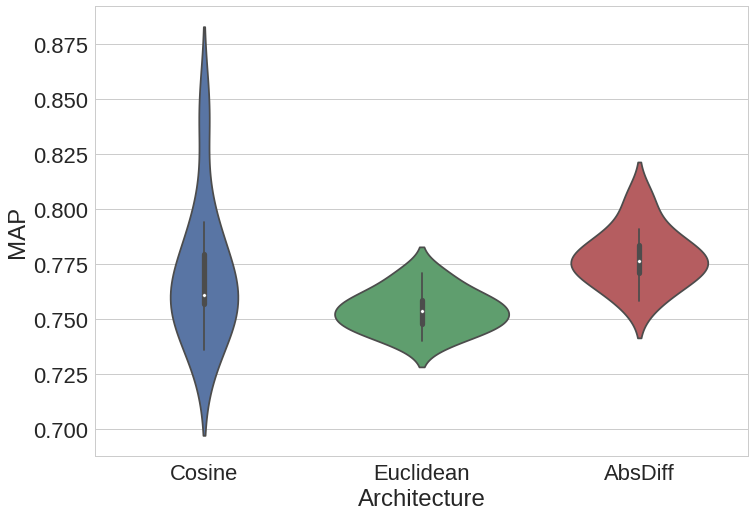

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MAP', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.75, 0.81)

/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 7 Text yticklabel objects>)

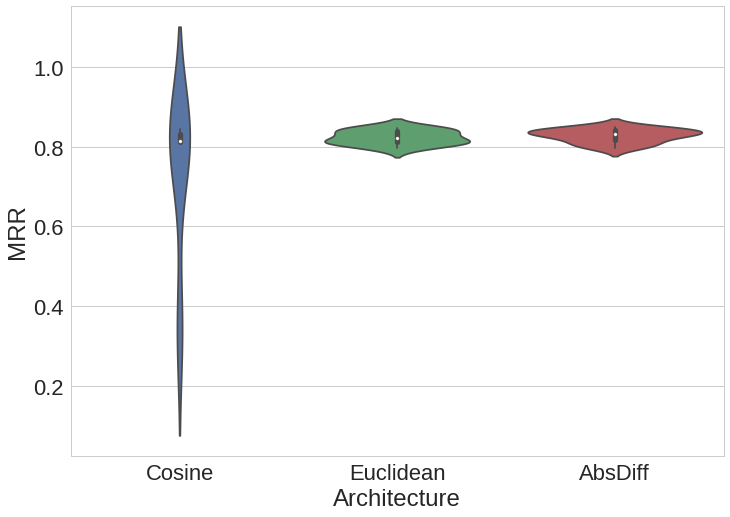

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MRR', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

## WikiQA

In [21]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [22]:
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

mpcnn: (0.6538, 0.7239)
Cosine: (0.6870, 0.6990)
Euclidean: (0.6865, 0.6939)
AbsDiff: (0.6220, 0.7272)


In [23]:
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

mpcnn: (0.6607, 0.7391)
Cosine: (0.6961, 0.7101)
Euclidean: (0.6993, 0.7080)
AbsDiff: (0.6320, 0.7414)


In [24]:
wikiqa_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
AbsDiff,0.67457,598413.8
Cosine,0.69298,598413.8
Euclidean,0.69021,598413.8
mpcnn,0.68884,598413.8


In [25]:
wikiqa_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
AbsDiff,0.68669,598413.8
Cosine,0.70312,598413.8
Euclidean,0.70365,598413.8
mpcnn,0.69994,598413.8


In [26]:
compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: Cosine comparison only
Median of MAP change compared with MP-CNN baseline: -0.0177
Mean of MAP change compared with MP-CNN baseline: 0.0041
Architecture: Euclidean comparison only
Median of MAP change compared with MP-CNN baseline: -0.0212
Mean of MAP change compared with MP-CNN baseline: 0.0014
Architecture: AbsDiff comparison only
Median of MAP change compared with MP-CNN baseline: -0.0136
Mean of MAP change compared with MP-CNN baseline: -0.0143


In [27]:
compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: Cosine comparison only
Median of MRR change compared with MP-CNN baseline: -0.0246
Mean of MRR change compared with MP-CNN baseline: 0.0032
Architecture: Euclidean comparison only
Median of MRR change compared with MP-CNN baseline: -0.0213
Mean of MRR change compared with MP-CNN baseline: 0.0037
Architecture: AbsDiff comparison only
Median of MRR change compared with MP-CNN baseline: -0.0151
Mean of MRR change compared with MP-CNN baseline: -0.0132


In [28]:
compare_change_to_baseline(wikiqa_map_vs_archs_dev, 'MAP')

Architecture: Cosine comparison only
Median of MAP change compared with MP-CNN baseline: -0.0089
Mean of MAP change compared with MP-CNN baseline: 0.0054
Architecture: Euclidean comparison only
Median of MAP change compared with MP-CNN baseline: -0.0073
Mean of MAP change compared with MP-CNN baseline: 0.0098
Architecture: AbsDiff comparison only
Median of MAP change compared with MP-CNN baseline: -0.0030
Mean of MAP change compared with MP-CNN baseline: -0.0145


In [29]:
compare_change_to_baseline(wikiqa_mrr_vs_archs_dev, 'MRR')

Architecture: Cosine comparison only
Median of MRR change compared with MP-CNN baseline: -0.0105
Mean of MRR change compared with MP-CNN baseline: 0.0050
Architecture: Euclidean comparison only
Median of MRR change compared with MP-CNN baseline: -0.0070
Mean of MRR change compared with MP-CNN baseline: 0.0101
Architecture: AbsDiff comparison only
Median of MRR change compared with MP-CNN baseline: -0.0046
Mean of MRR change compared with MP-CNN baseline: -0.0151


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(array([ 0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9]),
 <a list of 7 Text yticklabel objects>)

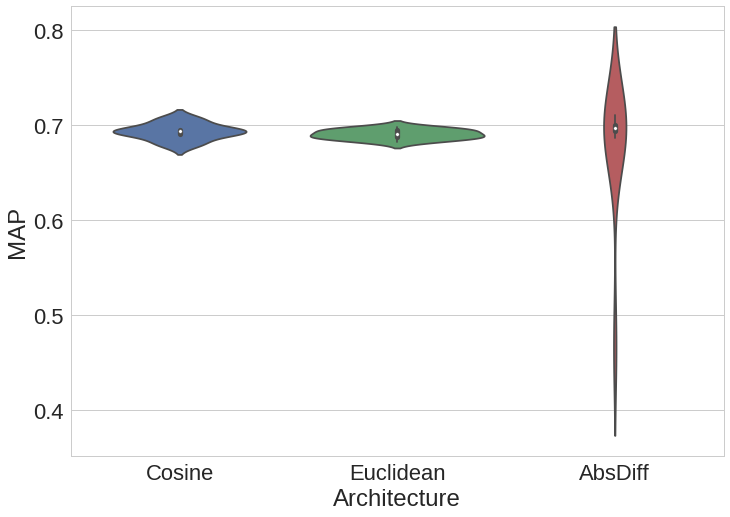

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MAP', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.ylim(0.6, 0.75)

## SICK

In [31]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [32]:
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

mpcnn: (0.8500, 0.8746)
Cosine: (0.8351, 0.8406)
Euclidean: (0.8552, 0.8591)
AbsDiff: (0.8686, 0.8730)


In [33]:
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

mpcnn: (0.8030, 0.8109)
Cosine: (0.7614, 0.7689)
Euclidean: (0.7943, 0.7996)
AbsDiff: (0.8038, 0.8113)


In [34]:
sick_pearson_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
AbsDiff,0.870824,598413.8
Cosine,0.837855,598413.8
Euclidean,0.857150,598413.8
mpcnn,0.862279,598413.8


In [35]:
sick_spearman_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
AbsDiff,0.807545,598413.8
Cosine,0.765165,598413.8
Euclidean,0.796956,598413.8
mpcnn,0.806939,598413.8


In [36]:
compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: Cosine comparison only
Median of pearson change compared with MP-CNN baseline: -0.0302
Mean of pearson change compared with MP-CNN baseline: -0.0244
Architecture: Euclidean comparison only
Median of pearson change compared with MP-CNN baseline: -0.0095
Mean of pearson change compared with MP-CNN baseline: -0.0051
Architecture: AbsDiff comparison only
Median of pearson change compared with MP-CNN baseline: 0.0034
Mean of pearson change compared with MP-CNN baseline: 0.0085


In [37]:
compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: Cosine comparison only
Median of spearman change compared with MP-CNN baseline: -0.0407
Mean of spearman change compared with MP-CNN baseline: -0.0418
Architecture: Euclidean comparison only
Median of spearman change compared with MP-CNN baseline: -0.0105
Mean of spearman change compared with MP-CNN baseline: -0.0100
Architecture: AbsDiff comparison only
Median of spearman change compared with MP-CNN baseline: 0.0007
Mean of spearman change compared with MP-CNN baseline: 0.0006


In [38]:
compare_change_to_baseline(sick_pearson_vs_archs_dev, 'pearson')

Architecture: Cosine comparison only
Median of pearson change compared with MP-CNN baseline: -0.0249
Mean of pearson change compared with MP-CNN baseline: -0.0202
Architecture: Euclidean comparison only
Median of pearson change compared with MP-CNN baseline: -0.0067
Mean of pearson change compared with MP-CNN baseline: -0.0004
Architecture: AbsDiff comparison only
Median of pearson change compared with MP-CNN baseline: 0.0047
Mean of pearson change compared with MP-CNN baseline: 0.0099


In [39]:
compare_change_to_baseline(sick_spearman_vs_archs_dev, 'spearman')

Architecture: Cosine comparison only
Median of spearman change compared with MP-CNN baseline: -0.0356
Mean of spearman change compared with MP-CNN baseline: -0.0373
Architecture: Euclidean comparison only
Median of spearman change compared with MP-CNN baseline: 0.0012
Mean of spearman change compared with MP-CNN baseline: 0.0018
Architecture: AbsDiff comparison only
Median of spearman change compared with MP-CNN baseline: 0.0095
Mean of spearman change compared with MP-CNN baseline: 0.0088


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(array([ 0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89]),
 <a list of 8 Text yticklabel objects>)

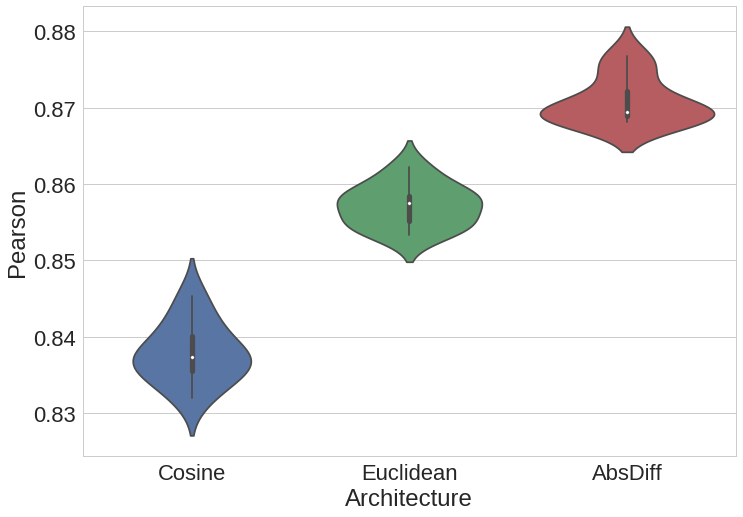

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('Pearson', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.86, 0.88)